In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
df = pd.read_parquet('../OUTPUT/evictions_matched.parquet')

In [45]:
df.shape

(630393, 81)

In [ ]:
## Set your desired match confidence here
confidence = 90
df = df.loc[df['match_confidence'] >= confidence]

In [47]:
df.head()

,plaintiff_name,defendant_name,defendant_zip,c2dp_case_id,county,fips,case_number,filed_date,case_type,debt_type,...,RA-Status,RA-Loc,StockInd,TotalShares,MergerInd,AssessInd,Is Series LLC,Is Protected Series,Series LLC ID,Name_normalized
0,"1 HIL MAR, INC","SCHOTT, HENRY J",23227.0,127_GV22000423-00,New Kent General District Court,127,GV22000423-00,2022-08-18,Unlawful Detainer,None,...,Active,810.0,NaN,NaN,None,1,None,None,None,hi
1,"1 HIL MAR, INC","SCHOTT, HENRY J",23227.0,127_GV22000423-00,New Kent General District Court,127,GV22000423-00,2022-08-18,Unlawful Detainer,None,...,Active,990.0,NaN,0.0,None,0,None,None,None,hi
2,1 SQ APTS LP,AYALA ERICA,23702.0,740_GV18012249-00,Portsmouth General District Court,740,GV18012249-00,2018-11-21,Unlawful Detainer,None,...,Active,510.0,NaN,NaN,None,1,None,None,None,apt
3,1 SQ APTS LP,DARDEN DAVID,23702.0,740_GV18012250-00,Portsmouth General District Court,740,GV18012250-00,2018-11-26,Unlawful Detainer,None,...,Active,510.0,NaN,NaN,None,1,None,None,None,apt
4,1 SQ APTS LP,GROOMS SHAVON,23702.0,740_GV18012251-00,Portsmouth General District Court,740,GV18012251-00,2018-11-26,Unlawful Detainer,None,...,Active,510.0,NaN,NaN,None,1,None,None,None,apt


In [73]:
df.shape

(630389, 82)

In [48]:
df.columns

Index(['plaintiff_name', 'defendant_name', 'defendant_zip', 'c2dp_case_id',
       'county', 'fips', 'case_number', 'filed_date', 'case_type', 'debt_type',
       'defendant_attorney', 'defendant_dba_ta', 'defendant_address',
       'defendant_count', 'all_defendant_names', 'all_defendant_addresses',
       'defendant_order_validation', 'hearing_count', 'latest_hearing_date',
       'latest_hearing_result', 'judgment', 'homestead_exemption_waived',
       'is_judgment_satisfied', 'date_satisfaction_filed',
       'further_case_information', 'costs', 'attorney_fees',
       'principal_amount', 'interest_award', 'possession',
       'writ_of_eviction_issued_date', 'other_amount', 'other_awarded',
       'clean_party_name', 'plaintiff_attorney', 'plaintiff_dba_ta',
       'plaintiff_address', 'plaintiff_count', 'all_plaintiff_names',
       'all_plaintiff_addresses', 'plaintiff_order_validation', 'filed_year',
       'filed_quarter', 'plaintiff_zip', 'serial_filing',
       'latest_filing

In [ ]:
# ### Heuristic Matching
# # Group by Registered Agent (RA-Name)
# ra_groups = df.groupby('RA-Name').size().reset_index(name='LLC_Count')
# ra_groups = ra_groups.sort_values(by='LLC_Count', ascending=False)

# # Group by Address (Street1)
# address_groups = df.groupby('Street1').size().reset_index(name='LLC_Count')
# address_groups = address_groups.sort_values(by='LLC_Count', ascending=False)

# # Group by composite key: RA-Name + Street1
# df['Composite_Key'] = df['RA-Name'] + '|' + df['Street1']
# composite_groups = df.groupby('Composite_Key').size().reset_index(name='LLC_Count')
# composite_groups = composite_groups.sort_values(by='LLC_Count', ascending=False)

In [ ]:
# print("Top groups by Registered Agent:")
# print(ra_groups.head(10))

Top groups by Registered Agent:
                                     RA-Name  LLC_Count
1247             CORPORATION SERVICE COMPANY      38404
901                   C T CORPORATION SYSTEM      26385
312                          ARVIND B   AMIN      12839
2795                          HORACE   JONES      11586
2883                             ICAFS  INC.      10694
7489              Vcorp Agent Services  Inc.      10372
5418        NATIONAL REGISTERED AGENTS  INC.       8185
7090                         THAO NHU   DINH       7786
7415  United States Corporation Agents  Inc.       7398
423                         Alperin Law PLLC       4071


In [ ]:
# print("Top groups by Street1:")
# print(address_groups.head(10))

Top groups by Street1:
                         Street1  LLC_Count
3663         208 GOLDEN MAPLE DR      12839
2548        1555 KING ST STE 200      11586
8039  6031 Connection Dr Ste 200       8786
8966         7704-C RICHMOND HWY       7786
4966          2922 Hathaway Road       5077
2616          160 CLUBHOUSE ROAD       4042
7753          560 LYNNHAVEN PKWY       3745
733      11 South Cameron Street       3663
6909   46400 BENEDICT DR STE 201       3663
7755       560 Lynnhaven Parkway       3454


In [ ]:
# print("Top groups by Composite Key:")
# print(composite_groups.head(10))

Top groups by Composite Key:
                                       Composite_Key  LLC_Count
363              ARVIND B   AMIN|208 GOLDEN MAPLE DR      12839
3992             HORACE   JONES|1555 KING ST STE 200      11586
9380             THAO NHU   DINH|7704-C RICHMOND HWY       7786
4113                  ICAFS  INC.|2922 Hathaway Road       5077
1889  CORPORATION SERVICE COMPANY|160 CLUBHOUSE ROAD       4042
7139      NATE L  ADAMS  III|11 South Cameron Street       3663
3261      ESMAIL   SHIRAZI|46400 BENEDICT DR STE 201       3663
9432   THOMAS G.  JOHNSON  JR.|560 Lynnhaven Parkway       3454
5845                Kenneth  W Hudson|2060 Meadow Rd       3432
4111                    ICAFS  INC.|2922 HATHAWAY RD       3340


A more robust approach

In [53]:
ra_groups = df.groupby('RA-Name').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
ra_groups = ra_groups.loc[ra_groups['LLC_Count'] > 1]

In [54]:
address_groups = df.groupby('Street1').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
address_groups = address_groups.loc[address_groups['LLC_Count'] > 1]

In [55]:
df['Composite_Key'] = df['RA-Name'] + '|' + df['Street1']
composite_groups = df.groupby('Composite_Key').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
composite_groups = composite_groups.loc[composite_groups['LLC_Count'] > 1]

In [56]:
print("Top groups by Registered Agent:")
print(ra_groups.head(10))

Top groups by Registered Agent:
                  RA-Name  LLC_Count  \
0                3337 LLC         11   
1     7820 Whitepine  LLC         56   
3           A   REISINGER         10   
4            A J   KALFUS         23   
5       A KEVIN   CARBONE          9   
7   A PATRICIA   MERRYMAN       2849   
11       AARON   CEVALLOS          2   
13         AARON   TRUMAN         21   
15         AARON B   COOK          3   
16    AARON CALEB   RIFFE         14   

                                       plaintiff_name  \
0   [VARADO LLC, VARADO LLC, VARADO LLC, VARADO LL...   
1   [NEWPORT TECH CENTER LLC, NEWPORT TECH CENTER ...   
3   [RIDGECREST PROPERTIES LLC, RIDGECREST PROPERT...   
4   [BRANT POINT PROPERTIES LLC, BRANT POINT PROPE...   
5   [CREDIT CORP SOLUTIONS INC, CREDIT CORP SOLUTI...   
7   [109 PERRY FEE LLC, 109 PERRY FEE LLC, 109 PER...   
11             [HERITAGE HOSP LLC, HERITAGE HOSP LLC]   
13  [CHANTILLY MEWS LTD DIVIDEND HOUSING, CHANTILL...   
15           [

In [57]:
print("Top groups by Street1:")
print(address_groups.head(10))

Top groups by Street1:
                  Street1  LLC_Count  \
0           1 AEC PARKWAY        132   
1              1 AEC PKWY        235   
2   1 American Ln Ste 220          4   
4    1 Boar's Head Pointe          9   
5       1 CENTRE PORT CIR          3   
6            1 COLLINS DR       1521   
7         1 COLLINS DRIVE        482   
8            1 Courage Ln          7   
9         1 ELMCROFT ROAD        362   
10             1 Engle St         10   

                                       plaintiff_name  \
0   [AERC RIVERSIDE STATION LLC, AERC RIVERSIDE ST...   
1   [AERC VIENNA METRO LLC, AERC VIENNA METRO LLC,...   
2   [CAVALRY SPV LLC, CAVALRY SPV LLC, CAVALRY SPV...   
4   [IVY GARDENS OF CHARLOTTESVILLE LLC, OLD IVY O...   
5   [M D BIVINS CONSTRUCTION LLC, M D BIVINS CONST...   
6   [1902 ATLANTIC LIMITED, BASYE LAND CO, BENTLEY...   
7   [801 CHASE CARIBE PLAC LLC, CHEVY CHASE FUNDIN...   
8   [DELASHMUTT VIRGINIA PROPERTIES, LLC, DELASHMU...   
9   [BLT ACP AVENTINE L

In [58]:
print("Top groups by Composite Key:")
print(composite_groups.head(10))

Top groups by Composite Key:
                                Composite_Key  LLC_Count  \
0                    3337 LLC|1003 Bragg Road         11   
1        7820 Whitepine  LLC|6501 GOLDLEAF DR         56   
3           A   REISINGER|4600 COX RD STE 320         10   
4                  A J   KALFUS|1337 BRANT RD         23   
5      A KEVIN   CARBONE|17534 RAVEN ROCKS RD          9   
7   A PATRICIA   MERRYMAN|800 MAIN ST STE 400       2849   
11      AARON   CEVALLOS|10124 Overlook Court          2   
13         AARON   TRUMAN|7707 Drexelbrook Rd         21   
15                 AARON B   COOK|1856 Oak Dr          3   
16   AARON CALEB   RIFFE|278 BISHOP HOLLOW DR         14   

                                       plaintiff_name  \
0   [VARADO LLC, VARADO LLC, VARADO LLC, VARADO LL...   
1   [NEWPORT TECH CENTER LLC, NEWPORT TECH CENTER ...   
3   [RIDGECREST PROPERTIES LLC, RIDGECREST PROPERT...   
4   [BRANT POINT PROPERTIES LLC, BRANT POINT PROPE...   
5   [CREDIT CORP SOLUTION

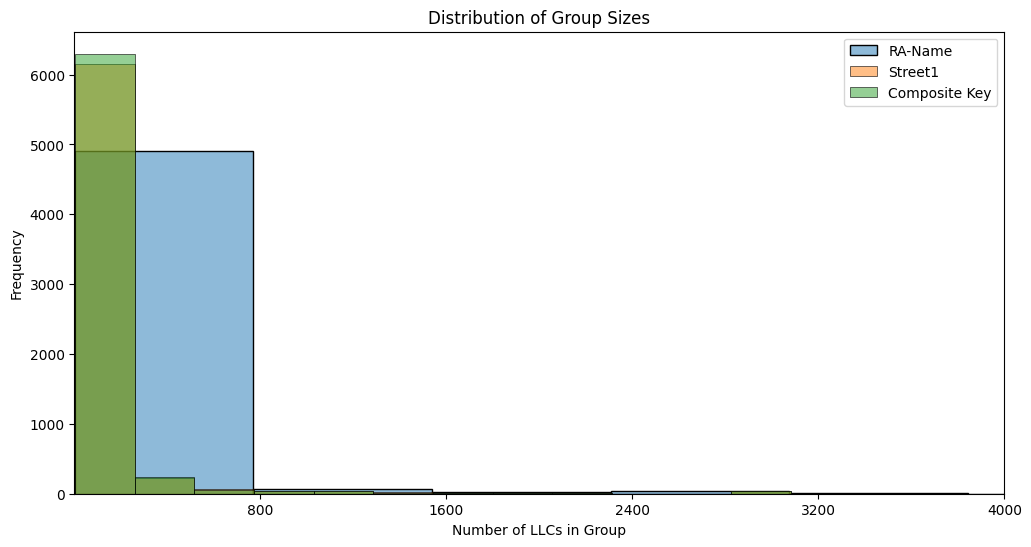

In [59]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(12, 6))
sns.histplot(ra_groups['LLC_Count'], bins=50, label='RA-Name', alpha=0.5)
sns.histplot(address_groups['LLC_Count'], bins=50, label='Street1', alpha=0.5)
sns.histplot(composite_groups['LLC_Count'], bins=50, label='Composite Key', alpha=0.5)

plt.xlabel('Number of LLCs in Group')
plt.ylabel('Frequency')
plt.title('Distribution of Group Sizes')
plt.legend()

plt.xlim(0, 4000) 
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=5))  # Limit to max 5 ticks

plt.savefig('../OUTPUT/group_size_distribution.png')
plt.show()
plt.close()

In [60]:
print("Top 5 RA-Name Groups:")
print(ra_groups[['RA-Name', 'LLC_Count']].sort_values(by='LLC_Count', ascending=False).head(5))
print("\nTop 5 Street1 Groups:")
print(address_groups[['Street1', 'LLC_Count']].sort_values(by='LLC_Count', ascending=False).head(5))
print("\nTop 5 Composite Key Groups:")
print(composite_groups[['Composite_Key', 'LLC_Count']].sort_values(by='LLC_Count', ascending=False).head(5))

Top 5 RA-Name Groups:
                          RA-Name  LLC_Count
1247  CORPORATION SERVICE COMPANY      38404
901        C T CORPORATION SYSTEM      26385
312               ARVIND B   AMIN      12839
2795               HORACE   JONES      11586
2883                  ICAFS  INC.      10694

Top 5 Street1 Groups:
                         Street1  LLC_Count
3663         208 GOLDEN MAPLE DR      12839
2548        1555 KING ST STE 200      11586
8039  6031 Connection Dr Ste 200       8786
8966         7704-C RICHMOND HWY       7786
4966          2922 Hathaway Road       5077

Top 5 Composite Key Groups:
                                       Composite_Key  LLC_Count
363              ARVIND B   AMIN|208 GOLDEN MAPLE DR      12839
3992             HORACE   JONES|1555 KING ST STE 200      11586
9380             THAO NHU   DINH|7704-C RICHMOND HWY       7786
4113                  ICAFS  INC.|2922 Hathaway Road       5077
1889  CORPORATION SERVICE COMPANY|160 CLUBHOUSE ROAD       4042


In [61]:
# ra_entities = df.merge(ra_groups[['RA-Name']], on='RA-Name', how='inner')[['Name', 'RA-Name', 'plaintiff_name']]
# address_entities = df.merge(address_groups[['Street1']], on='Street1', how='inner')[['Name', 'Street1', 'plaintiff_name']]

# overlap = pd.merge(
#     ra_entities,
#     address_entities,
#     on='Name',
#     how='inner',
#     suffixes=('_ra', '_addr')
# )
# print("\nNumber of overlapping LLCs (RA-Name and Street1):", len(overlap))
# print("Sample overlapping LLCs (first 5):")
# print(overlap[['Name', 'RA-Name', 'Street1', 'plaintiff_name_ra']].head(5))

In [62]:
def analyze_llc_networks(df):
    """
    Identify and analyze networks of LLCs with shared RAs or addresses
    """
    # First, let's enhance the composite groups by extracting more stats
    composite_groups = df.groupby('Composite_Key').agg({
        'Name': 'count',
        'plaintiff_name': list,
        'IncorpDate': list,
        'Zip': list,
        'filed_date': list,
        'serial_filing': list
    }).rename(columns={'Name': 'LLC_Count'}).reset_index()
    
    composite_groups = composite_groups.loc[composite_groups['LLC_Count'] > 1]
    
    # Calculate the timespan between earliest and latest incorporation dates
    composite_groups['IncorpDate_Parsed'] = composite_groups['IncorpDate'].apply(
        lambda dates: [pd.to_datetime(d) for d in dates if pd.notna(d)]
    )
    
    composite_groups['Timespan_Days'] = composite_groups['IncorpDate_Parsed'].apply(
        lambda dates: (max(dates) - min(dates)).days if len(dates) > 1 else 0
    )
    
    # Calculate the timespan between earliest and latest filing dates
    composite_groups['FilingDate_Parsed'] = composite_groups['filed_date'].apply(
        lambda dates: [pd.to_datetime(d) for d in dates if pd.notna(d)]
    )
    
    composite_groups['Filing_Timespan_Days'] = composite_groups['FilingDate_Parsed'].apply(
        lambda dates: (max(dates) - min(dates)).days if len(dates) > 1 else 0
    )
    
    # Calculate how many of the LLCs are serial filers
    composite_groups['Serial_Filer_Count'] = composite_groups['serial_filing'].apply(
        lambda x: sum([1 for filing in x if filing == True])
    )
    
    composite_groups['Serial_Filer_Pct'] = composite_groups['Serial_Filer_Count'] / composite_groups['LLC_Count']
    
    # Sort by number of connected LLCs
    large_networks = composite_groups.sort_values('LLC_Count', ascending=False).head(20)
    
    return composite_groups, large_networks

In [63]:
composite_groups, large_networks = analyze_llc_networks(df)

Some quick statistics

In [64]:
print("=== RA Group Statistics ===")
print(f"Number of RAs with multiple LLCs: {len(ra_groups)}")
print(f"Largest RA network has {ra_groups['LLC_Count'].max()} LLCs")
print(f"Average LLCs per RA: {ra_groups['LLC_Count'].mean():.2f}")
print(f"Median LLCs per RA: {ra_groups['LLC_Count'].median():.2f}")
print(f"Total LLCs in RA networks: {ra_groups['LLC_Count'].sum()}")

print("\n=== Address Group Statistics ===")
print(f"Number of addresses with multiple LLCs: {len(address_groups)}")
print(f"Largest address network has {address_groups['LLC_Count'].max()} LLCs")
print(f"Average LLCs per address: {address_groups['LLC_Count'].mean():.2f}")
print(f"Median LLCs per address: {address_groups['LLC_Count'].median():.2f}")
print(f"Total LLCs in address networks: {address_groups['LLC_Count'].sum()}")

print("\n=== Composite Key Group Statistics ===")
print(f"Number of RA-Address combinations with multiple LLCs: {len(composite_groups)}")
print(f"Largest composite network has {composite_groups['LLC_Count'].max()} LLCs")
print(f"Average LLCs per composite key: {composite_groups['LLC_Count'].mean():.2f}")
print(f"Median LLCs per composite key: {composite_groups['LLC_Count'].median():.2f}")
print(f"Total LLCs in composite networks: {composite_groups['LLC_Count'].sum()}")


=== RA Group Statistics ===
Number of RAs with multiple LLCs: 5058
Largest RA network has 38404 LLCs
Average LLCs per RA: 117.94
Median LLCs per RA: 6.00
Total LLCs in RA networks: 596525

=== Address Group Statistics ===
Number of addresses with multiple LLCs: 6627
Largest address network has 12839 LLCs
Average LLCs per address: 94.56
Median LLCs per address: 7.00
Total LLCs in address networks: 626637

=== Composite Key Group Statistics ===
Number of RA-Address combinations with multiple LLCs: 6756
Largest composite network has 12839 LLCs
Average LLCs per composite key: 88.16
Median LLCs per composite key: 7.00
Total LLCs in composite networks: 595614


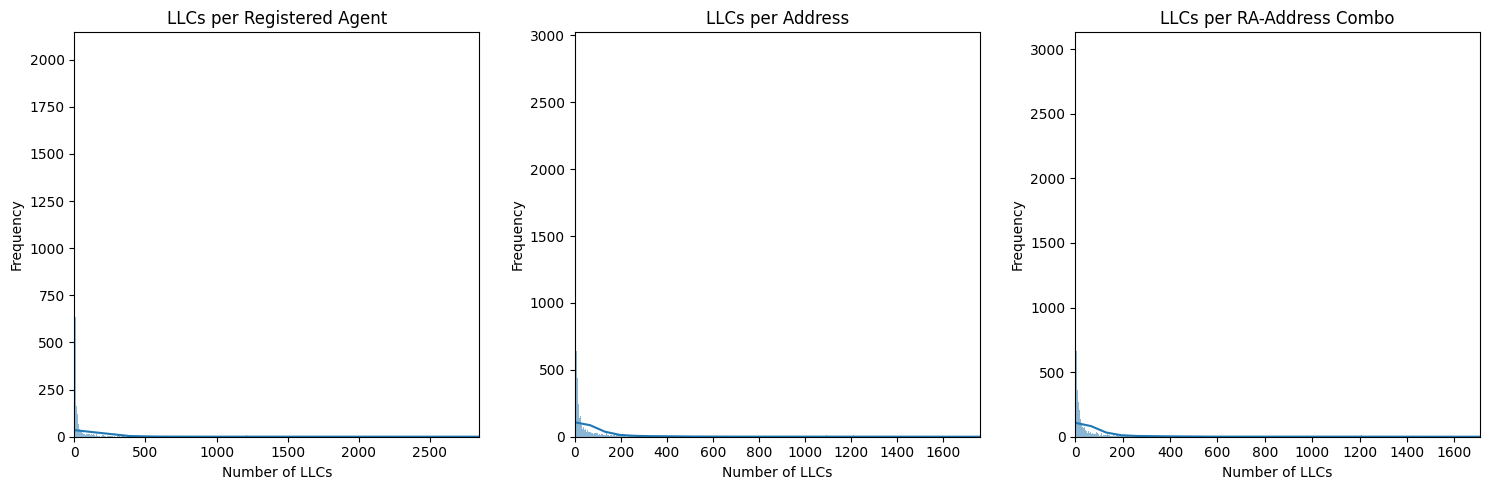

In [65]:
ra_xlim = ra_groups['LLC_Count'].quantile(0.99)
address_xlim = address_groups['LLC_Count'].quantile(0.99)
composite_xlim = composite_groups['LLC_Count'].quantile(0.99)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(ra_groups['LLC_Count'], kde=True)
plt.title('LLCs per Registered Agent')
plt.xlabel('Number of LLCs')
plt.ylabel('Frequency')
plt.xlim(0, ra_xlim)

plt.subplot(1, 3, 2)
sns.histplot(address_groups['LLC_Count'], kde=True)
plt.title('LLCs per Address')
plt.xlabel('Number of LLCs')
plt.ylabel('Frequency')
plt.xlim(0, address_xlim)

plt.subplot(1, 3, 3)
sns.histplot(composite_groups['LLC_Count'], kde=True)
plt.title('LLCs per RA-Address Combo')
plt.xlabel('Number of LLCs')
plt.ylabel('Frequency')
plt.xlim(0, composite_xlim)

plt.tight_layout()
plt.savefig('../OUTPUT/network_size_distributions.png')
plt.show()
plt.close()


In [66]:
top_ras = ra_groups.sort_values('LLC_Count', ascending=False).head(5)
print("\n=== Top 5 Registered Agents by LLC Count ===")
for idx, row in top_ras.iterrows():
    print(f"RA: {row['RA-Name']}, LLC Count: {row['LLC_Count']}")
    print(f"  LLC Names: {', '.join(row['plaintiff_name'][:3])}...")
    
top_addresses = address_groups.sort_values('LLC_Count', ascending=False).head(5)
print("\n=== Top 5 Addresses by LLC Count ===")
for idx, row in top_addresses.iterrows():
    print(f"Address: {row['Street1']}, LLC Count: {row['LLC_Count']}")
    print(f"  LLC Names: {', '.join(row['plaintiff_name'][:3])}...")

top_composites = composite_groups.sort_values('LLC_Count', ascending=False).head(5)
print("\n=== Top 5 RA-Address Combinations by LLC Count ===")
for idx, row in top_composites.iterrows():
    ra, addr = row['Composite_Key'].split('|')
    print(f"RA: {ra}, Address: {addr}, LLC Count: {row['LLC_Count']}")
    print(f"  LLC Names: {', '.join(row['plaintiff_name'][:3])}...")


=== Top 5 Registered Agents by LLC Count ===
RA: CORPORATION SERVICE COMPANY, LLC Count: 38404
  LLC Names: 1001 EAST MAIN EQUITIES LLC, 10035 SLIDING HILL ROAD LLC, 1011 HULL STREET LP...
RA: C T CORPORATION SYSTEM, LLC Count: 26385
  LLC Names: 1002 10056 WOODSTOCK LN PROPERTY LLC, 11084 MARSH ROAD LLC, 12751 FAIR LAKES CIRCLE OWNER LLC...
RA: ARVIND B   AMIN, LLC Count: 12839
  LLC Names: 319 WINSTON ASSOCIATES LLC SUCC IN INT TO, 319 WINSTON ASSOCIATES LLC SUCC IN INT TO, 319 WINSTON ASSOCIATES LLC SUCC IN INT TO...
RA: HORACE   JONES, LLC Count: 11586
  LLC Names: 1 SQ APTS LP, 1 SQ APTS LP, 1 SQ APTS LP...
RA: ICAFS  INC., LLC Count: 10694
  LLC Names: 1903 WHITCOMB LLC BY REDEFINE PROPERTY, 1903 WHITCOMB LLC BY REDEFINE PROPERTY, 403 STOCKTON STREET LLC CO PMC PROPERTY...

=== Top 5 Addresses by LLC Count ===
Address: 208 GOLDEN MAPLE DR, LLC Count: 12839
  LLC Names: 319 WINSTON ASSOCIATES LLC SUCC IN INT TO, 319 WINSTON ASSOCIATES LLC SUCC IN INT TO, 319 WINSTON ASSOCIATES LL

=== LLC Network Size Statistics ===
Total networks identified: 6756
Average LLCs per network: 88.16
Median LLCs per network: 7.0
Largest network size: 12839.0


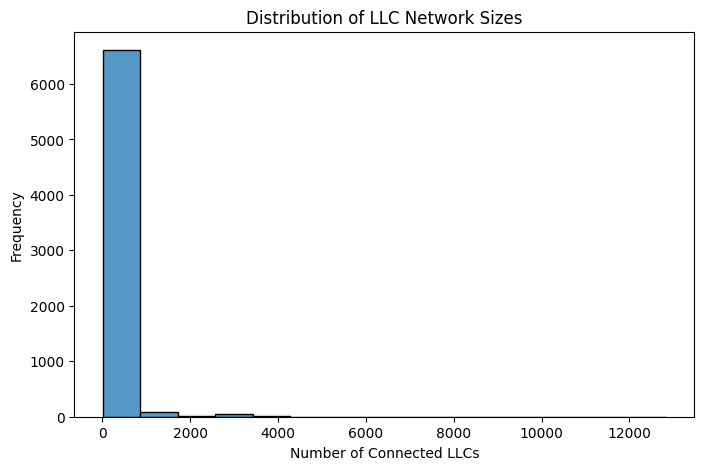

In [67]:
network_size_stats = composite_groups['LLC_Count'].describe()
print("=== LLC Network Size Statistics ===")
print(f"Total networks identified: {len(composite_groups)}")
print(f"Average LLCs per network: {network_size_stats['mean']:.2f}")
print(f"Median LLCs per network: {network_size_stats['50%']:.1f}")
print(f"Largest network size: {network_size_stats['max']}")

plt.figure(figsize=(8, 5))
sns.histplot(composite_groups['LLC_Count'], bins=15)
plt.title('Distribution of LLC Network Sizes')
plt.xlabel('Number of Connected LLCs')
plt.ylabel('Frequency')
plt.savefig('../OUTPUT/network_sizes.png')


=== LLC Formation Timeline Analysis ===
Average timespan of LLC formations within networks: 130.3 days
Median formation timespan: 0.0 days
Networks with rapid LLC formation (≤30 days): 6215 (92.0%)


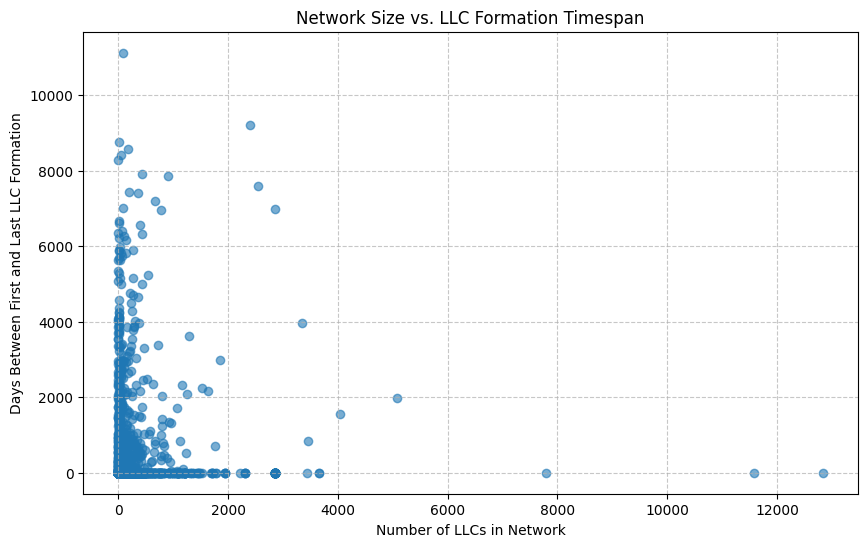

In [68]:
print("\n=== LLC Formation Timeline Analysis ===")
formation_stats = composite_groups['Timespan_Days'].describe()
print(f"Average timespan of LLC formations within networks: {formation_stats['mean']:.1f} days")
print(f"Median formation timespan: {formation_stats['50%']:.1f} days")

# Count networks with rapid LLC formation (within 30 days)
rapid_formation = composite_groups[composite_groups['Timespan_Days'] <= 30]
print(f"Networks with rapid LLC formation (≤30 days): {len(rapid_formation)} ({len(rapid_formation)/len(composite_groups):.1%})")

plt.figure(figsize=(10, 6))
plt.scatter(composite_groups['LLC_Count'], composite_groups['Timespan_Days'], alpha=0.6)
plt.title('Network Size vs. LLC Formation Timespan')
plt.xlabel('Number of LLCs in Network')
plt.ylabel('Days Between First and Last LLC Formation')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('../OUTPUT/formation_timespan_scatter.png')


=== Serial Filing Analysis ===
Average serial filer percentage within networks: 20.9%
Networks with 100% serial filers: 62
Networks with >75% serial filers: 139


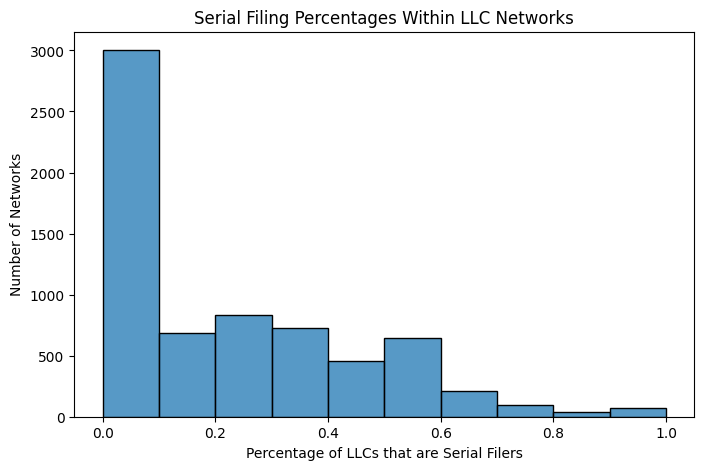

In [69]:
# Analysis of serial filing within networks
print("\n=== Serial Filing Analysis ===")
print(f"Average serial filer percentage within networks: {composite_groups['Serial_Filer_Pct'].mean():.1%}")
print(f"Networks with 100% serial filers: {len(composite_groups[composite_groups['Serial_Filer_Pct'] == 1])}")
print(f"Networks with >75% serial filers: {len(composite_groups[composite_groups['Serial_Filer_Pct'] > 0.75])}")

# Quick histogram of serial filing percentages
plt.figure(figsize=(8, 5))
sns.histplot(composite_groups['Serial_Filer_Pct'], bins=10)
plt.title('Serial Filing Percentages Within LLC Networks')
plt.xlabel('Percentage of LLCs that are Serial Filers')
plt.ylabel('Number of Networks')
plt.savefig('../OUTPUT/serial_filing_hist.png')

In [70]:
# Analyze filing timespans - how long networks are active in filings
print("\n=== Eviction Filing Timeline Analysis ===")
filing_stats = composite_groups['Filing_Timespan_Days'].describe()
print(f"Average active filing period: {filing_stats['mean']:.1f} days")
print(f"Median active filing period: {filing_stats['50%']:.1f} days")
print(f"Longest active filing period: {filing_stats['max']:.1f} days")

# Calculate filing density (filings per day)
composite_groups['Filing_Density'] = composite_groups['LLC_Count'] / (composite_groups['Filing_Timespan_Days'] + 1)  # +1 to avoid division by zero
print(f"Average filing density: {composite_groups['Filing_Density'].mean():.2f} filings per day")
print(f"Maximum filing density: {composite_groups['Filing_Density'].max():.2f} filings per day")


=== Eviction Filing Timeline Analysis ===
Average active filing period: 1073.4 days
Median active filing period: 1021.0 days
Longest active filing period: 2186.0 days
Average filing density: 0.20 filings per day
Maximum filing density: 23.00 filings per day


In [71]:
# Examine the largest networks in detail
print("\n=== Top 5 Largest LLC Networks ===")
for idx, row in large_networks.head(5).iterrows():
    ra, addr = row['Composite_Key'].split('|')
    print(f"\nNetwork #{idx+1}: {row['LLC_Count']} LLCs")
    print(f"RA: {ra}, Address: {addr}")
    print(f"LLCs formed over {row['Timespan_Days']} days")
    print(f"Active filing period: {row['Filing_Timespan_Days']} days")
    print(f"Serial filer percentage: {row['Serial_Filer_Pct']:.1%}")
    print(f"Sample LLCs: {', '.join(row['plaintiff_name'][:3])}")


=== Top 5 Largest LLC Networks ===

Network #364: 12839 LLCs
RA: ARVIND B   AMIN, Address: 208 GOLDEN MAPLE DR
LLCs formed over 0 days
Active filing period: 2179 days
Serial filer percentage: 55.8%
Sample LLCs: 319 WINSTON ASSOCIATES LLC SUCC IN INT TO, 319 WINSTON ASSOCIATES LLC SUCC IN INT TO, 319 WINSTON ASSOCIATES LLC SUCC IN INT TO

Network #3993: 11586 LLCs
RA: HORACE   JONES, Address: 1555 KING ST STE 200
LLCs formed over 0 days
Active filing period: 2179 days
Serial filer percentage: 50.9%
Sample LLCs: 1 SQ APTS LP, 1 SQ APTS LP, 1 SQ APTS LP

Network #9381: 7786 LLCs
RA: THAO NHU   DINH, Address: 7704-C RICHMOND HWY
LLCs formed over 0 days
Active filing period: 2184 days
Serial filer percentage: 34.8%
Sample LLCs: ARUNDINA LLC, COG AND JOB HOLDINGS LLC, JK PROPERTY HOLDINGS LP

Network #4114: 5077 LLCs
RA: ICAFS  INC., Address: 2922 Hathaway Road
LLCs formed over 1968 days
Active filing period: 2158 days
Serial filer percentage: 64.4%
Sample LLCs: CHVA LLC, CHVA LLC, CHVA LLC


=== Formation to Filing Timeline Analysis ===
Average days from network formation to first filing: 2338.4
Networks filing evictions within 30 days of formation: 967


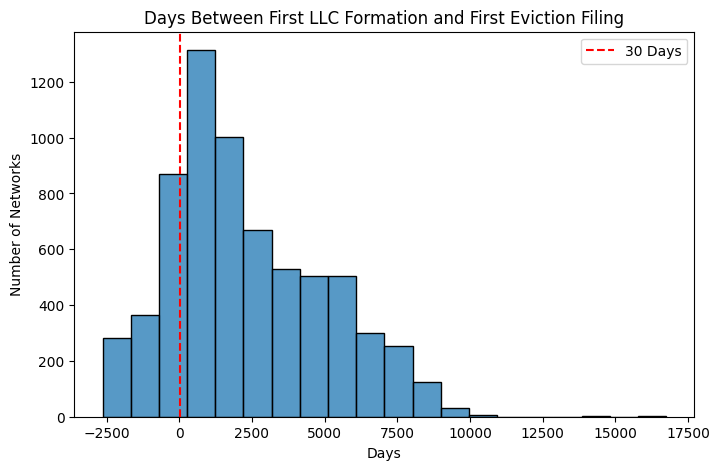

In [72]:
# Calculate time between LLC formation and first filing
composite_groups['Avg_Days_To_First_Filing'] = composite_groups.apply(
    lambda row: (min(row['FilingDate_Parsed']) - min(row['IncorpDate_Parsed'])).days 
    if len(row['FilingDate_Parsed']) > 0 and len(row['IncorpDate_Parsed']) > 0 
    else np.nan, axis=1
)

print("\n=== Formation to Filing Timeline Analysis ===")
print(f"Average days from network formation to first filing: {composite_groups['Avg_Days_To_First_Filing'].mean():.1f}")
print(f"Networks filing evictions within 30 days of formation: {len(composite_groups[composite_groups['Avg_Days_To_First_Filing'] <= 30])}")

# Quick histogram
plt.figure(figsize=(8, 5))
sns.histplot(composite_groups['Avg_Days_To_First_Filing'].dropna(), bins=20)
plt.title('Days Between First LLC Formation and First Eviction Filing')
plt.xlabel('Days')
plt.ylabel('Number of Networks')
plt.axvline(x=30, color='r', linestyle='--', label='30 Days')
plt.legend()
plt.savefig('../OUTPUT/formation_to_filing_hist.png')